In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Exploratory Data Analysis

## Analyzing Data Distribution

In [2]:
image_list = []
base_dir = 'trafficsigns_dataset'

# Loop through each directory and append only images to image_list
for filepath in glob.glob(os.path.join(base_dir, '*', '*', '*.png')):
    filename = os.path.basename(filepath)
    sign_type = os.path.basename(os.path.dirname(filepath))
    sign_shape = os.path.basename(os.path.dirname(os.path.dirname(filepath)))
    image_path = os.path.join(sign_shape, sign_type)

    img = Image.open(filepath)  

    image_list.append(('./' + filepath, image_path, filename, sign_shape, sign_type, f"{img.width}x{img.height}"))
    img.close()
    
# create dataframe
data = pd.DataFrame(data=image_list, columns=['filepath', 'image_path', 'filename' ,'sign_shape' ,'sign_type', 'dimension'])

In [3]:
data.head(10)

,filepath,image_path,filename,sign_shape,sign_type,dimension
0,./trafficsigns_dataset/diamond/rightofway/0003...,diamond/rightofway,00039_00001.png,diamond,rightofway,28x28
1,./trafficsigns_dataset/diamond/rightofway/0180...,diamond/rightofway,01803_00002.png,diamond,rightofway,28x28
2,./trafficsigns_dataset/diamond/rightofway/0170...,diamond/rightofway,01702_00000.png,diamond,rightofway,28x28
3,./trafficsigns_dataset/diamond/rightofway/0011...,diamond/rightofway,00111_00001.png,diamond,rightofway,28x28
4,./trafficsigns_dataset/diamond/rightofway/0123...,diamond/rightofway,01231_00003.png,diamond,rightofway,28x28
5,./trafficsigns_dataset/diamond/rightofway/0095...,diamond/rightofway,00957_00002.png,diamond,rightofway,28x28
6,./trafficsigns_dataset/diamond/rightofway/0123...,diamond/rightofway,01231_00002.png,diamond,rightofway,28x28
7,./trafficsigns_dataset/diamond/rightofway/0011...,diamond/rightofway,00111_00000.png,diamond,rightofway,28x28
8,./trafficsigns_dataset/diamond/rightofway/0170...,diamond/rightofway,01702_00001.png,diamond,rightofway,28x28
9,./trafficsigns_dataset/diamond/rightofway/0101...,diamond/rightofway,01013_00002.png,diamond,rightofway,28x28


In [4]:
# Output the result.
print("Following are the count of the number of images in each shape: \n")
data['image_path'].value_counts()

Following are the count of the number of images in each shape: 



image_path
triangle/warning          695
round/noentry             375
round/speed               316
round/bicycle             285
diamond/rightofway        282
square/parking            276
round/noparking           242
triangle/giveway          231
square/continue           199
round/trafficdirective    195
round/limitedtraffic      125
round/traveldirection     124
square/laneend            118
round/roundabout           98
square/crossing            95
hex/stop                   43
Name: count, dtype: int64

### Now I will analyze the number of images in each sub-directory i.e. image type in each shape using histogram

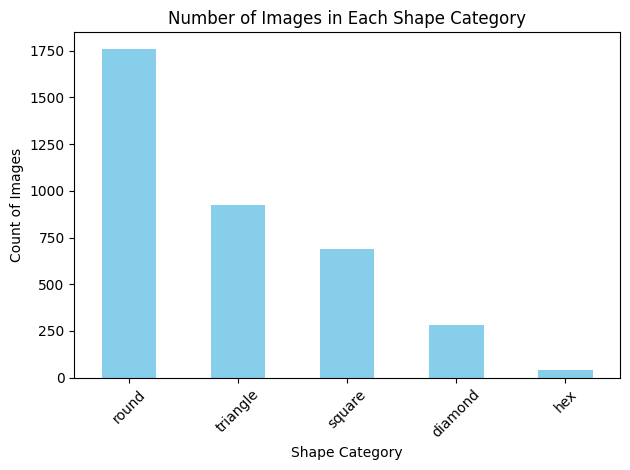

In [5]:
# plot histogram of sign shapes
data['sign_shape'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images in Each Shape Category')
plt.xlabel('Shape Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()


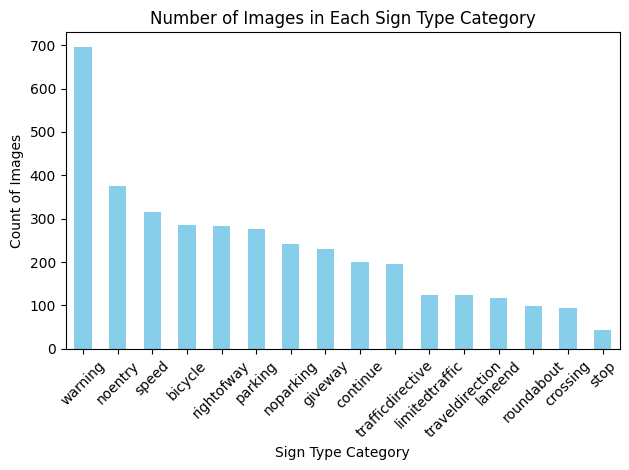

In [6]:
# plot histogram of sign shapes
data['sign_type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Images in Each Sign Type Category')
plt.xlabel('Sign Type Category')
plt.ylabel('Count of Images')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to ensure everything fits without overlap
plt.show()


## Analyzing Size Distribution

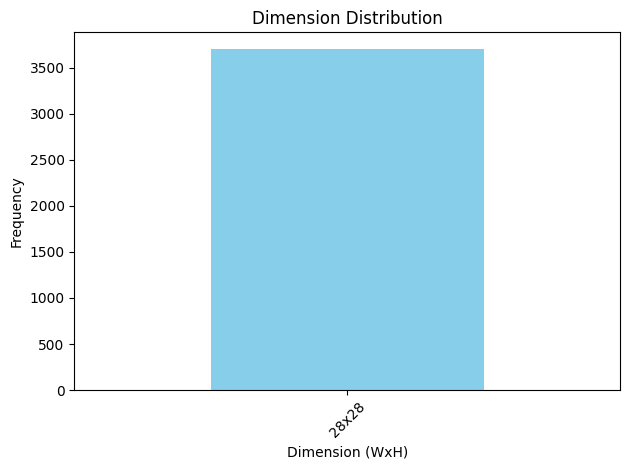

In [7]:
# Plotting
data['dimension'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Dimension Distribution')
plt.xlabel('Dimension (WxH)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Color Analysis

The following code computes and visualizes the average distribution of pixel intensities for the Red, Green, and Blue channels across all images in a specified dataset. It does this by:

1. Initializing storage to accumulate color data and track the number of images.
2. Iterating through the dataset's directory structure, processing each image to extract its color histograms.
3. Averaging these histograms by channel to get a sense of the typical color profile across the dataset.
4. Plotting the averaged histograms for visual analysis, presenting the commonality of pixel intensities in each color channel across the dataset.
The resulting visualizations provide insights into the dominant colors and brightness levels within the traffic sign images, which is valuable for understanding the data's characteristics and preparing for machine learning tasks.

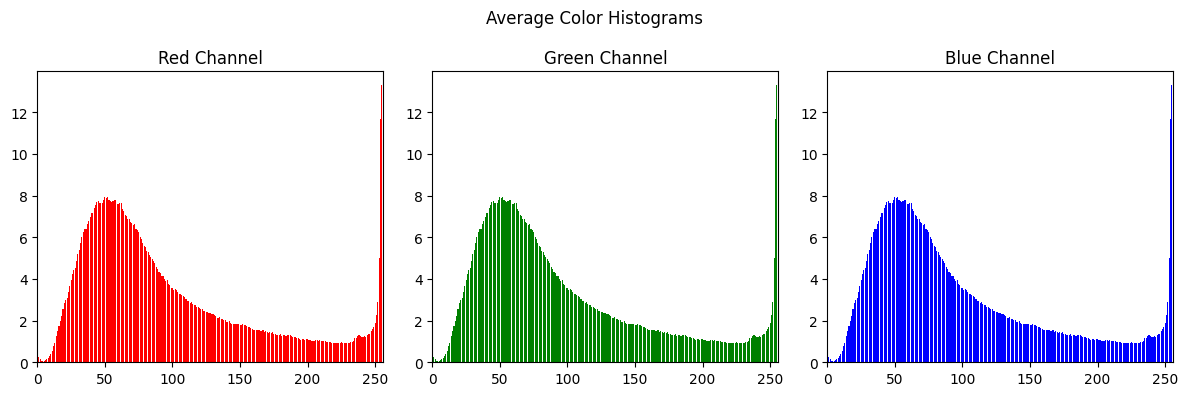

In [8]:
color_sums = [np.zeros(256), np.zeros(256), np.zeros(256)]  # For RGB channels
num_images = 0

# Loop through each subdirectory and compute color histograms
for image in image_list:
    file_path = image[0]
    with Image.open(file_path) as img:
        img = img.convert('RGB')  # Ensure image is in RGB
        for i in range(3):  # RGB channels
            hist, _ = np.histogram(img.getdata(band=i), bins=256, range=(0, 256))
            color_sums[i] += hist
        num_images += 1

# Calculate the average histograms
avg_histograms = [sums / num_images for sums in color_sums]

# Plot the average histograms
plt.figure(figsize=(12, 4))
colors = ['Red', 'Green', 'Blue']
for i, color in enumerate(colors):
    plt.subplot(1, 3, i + 1)
    plt.bar(range(256), avg_histograms[i], color=color.lower())
    plt.title(f'{color} Channel')
    plt.xlim([0, 256])
plt.suptitle('Average Color Histograms')
plt.tight_layout()
plt.show()


The following function checks whether a given image is in grayscale or not. 

In [9]:
def is_grey_scale(img_path):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i, j))
            if r != g or r != b:
                return False
    return True

The following code is designed to automate the process of checking each image in the dataset to determine whether it is in grayscale or not. Here's what each part of the script does:

1. Set Base Directory: The base_dir variable is set to the directory containing the dataset, labeled 'trafficsigns_dataset'.
2. Iterate Through Directory Structure: The script loops through each subdirectory, which represents different shapes and types of traffic signs.
3. Open Each Image: Each image file is opened, and a check is performed to see if the image is in grayscale.
4. Check for Color: The is_grey_scale function (not shown in this snippet) is called for each image. This function checks if each pixel has the same value for the red, green, and blue color channels. If a pixel is found with differing values, the image is not in grayscale.
5. Output Result: If a colored image is found (meaning the image is not in grayscale), the script prints the path of the image and a message stating that not all images are in grayscale.
6. Early Exit: Once a single colored image is found, the script breaks out of the loop, ending the execution. This is done because only one instance of a colored image is needed to determine that the dataset is not entirely in grayscale.

In [10]:
for image in image_list:
    file_path = image[0]
    if not is_grey_scale(file_path):
        print(f"Colored image found: {file_path}")
        print("Not All Images Are Gray")
        break  # If one colored image is found, we can stop checking


## Data Splitting

Since we are are going to test our model with real world data which would be completely unseen, we are only splitting it into train and validation in 80 - 20 percent respectively.

In [11]:
data.info

<bound method DataFrame.info of                                                filepath  \
0     ./trafficsigns_dataset/diamond/rightofway/0003...   
1     ./trafficsigns_dataset/diamond/rightofway/0180...   
2     ./trafficsigns_dataset/diamond/rightofway/0170...   
3     ./trafficsigns_dataset/diamond/rightofway/0011...   
4     ./trafficsigns_dataset/diamond/rightofway/0123...   
...                                                 ...   
3694  ./trafficsigns_dataset/round/trafficdirective/...   
3695  ./trafficsigns_dataset/round/trafficdirective/...   
3696  ./trafficsigns_dataset/round/trafficdirective/...   
3697  ./trafficsigns_dataset/round/trafficdirective/...   
3698  ./trafficsigns_dataset/round/trafficdirective/...   

                  image_path         filename sign_shape         sign_type  \
0         diamond/rightofway  00039_00001.png    diamond        rightofway   
1         diamond/rightofway  01803_00002.png    diamond        rightofway   
2         diamond/rightof

In [12]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=2024)

print("Train data : {}, Val Data: {}".format(train_data.shape[0], val_data.shape[0]))

Train data : 2959, Val Data: 740


### Data Leakage Check

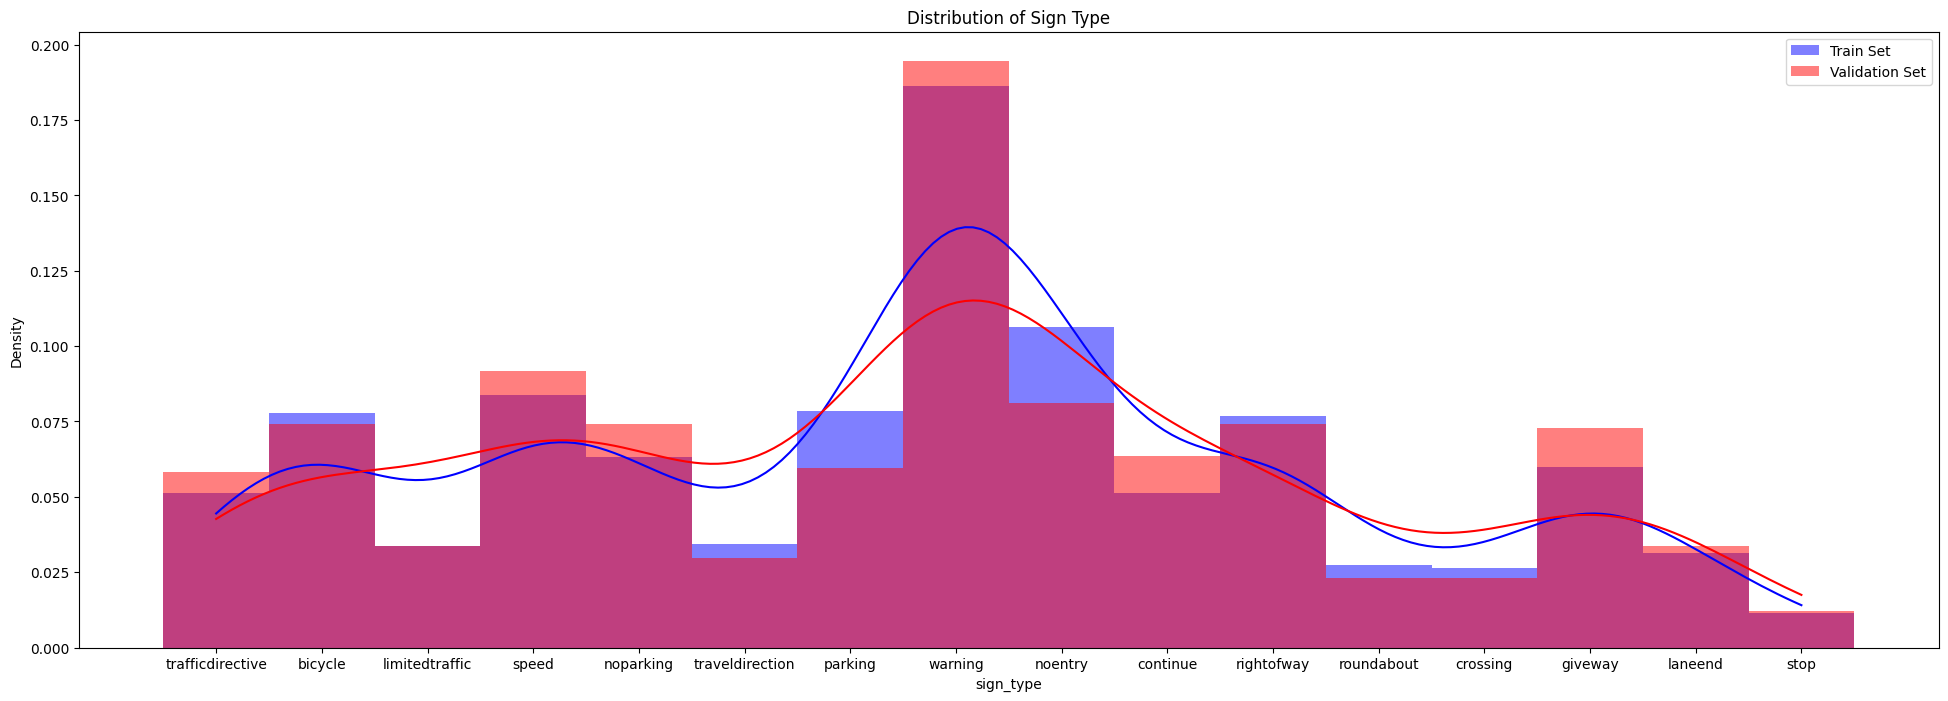

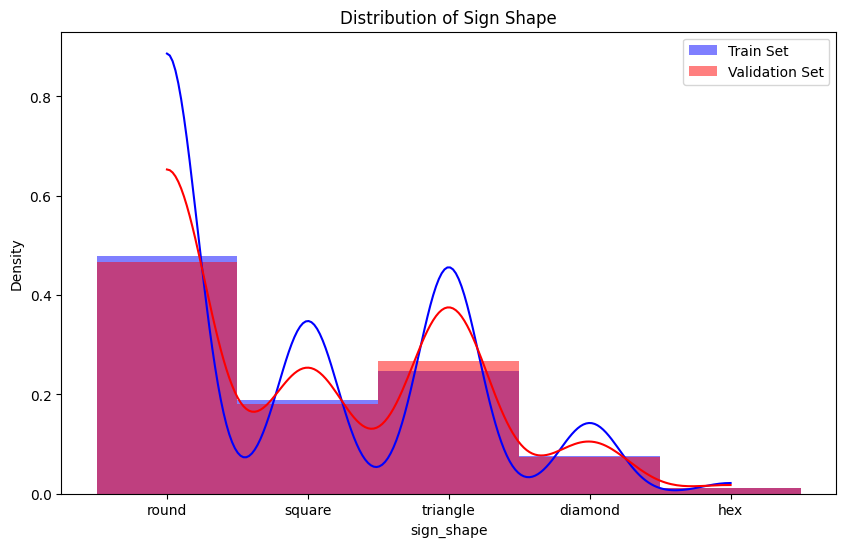

In [13]:
# Figure for 'sign_type'
plt.figure(figsize=(24, 8))  # Adjust the figure size as needed for clarity
sns.histplot(train_data['sign_type'], color="blue", label='Train Set', kde=True, stat="density", linewidth=0, alpha=0.5)
sns.histplot(val_data['sign_type'], color="red", label='Validation Set', kde=True, stat="density", linewidth=0, alpha=0.5)
plt.title('Distribution of Sign Type')
plt.legend()
plt.show()

# Figure for 'sign_shape'
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed for clarity
sns.histplot(train_data['sign_shape'], color="blue", label='Train Set', kde=True, stat="density", linewidth=0, alpha=0.5)
sns.histplot(val_data['sign_shape'], color="red", label='Validation Set', kde=True, stat="density", linewidth=0, alpha=0.5)
plt.title('Distribution of Sign Shape')
plt.legend()
plt.show()


#### Distribution of Sign Type
- **Overlap and Similarity**: Both training and validation sets show similar distributions for `sign_type`, suggesting that the validation set mirrors the training data well.
- **Density Peaks and Values**: There are consistent peaks across both datasets, indicating that each `sign_type` is represented similarly in both, which is crucial for model training.

#### Distribution of Sign Shape
- **Shape Distribution**: The histograms for `sign_shape` also demonstrate good overlap between the training and validation sets, showing that both sets contain similar proportions of each shape type.
- **Density and Peaks**: The presence of consistent peaks for common shapes like "round" and "square" across both datasets further confirms the good representation in both sets.

### Conclusion on Data Leakage
- **No Apparent Data Leakage**: The histograms do not display typical signs of data leakage, where features in the training set would excessively influence the model in a way not replicable in the validation set.
- **Good Dataset Split**: The data split appears to be effective, suggesting that the validation set can provide a realistic indication of the model's performance on new, unseen data.

These observations indicate that the dataset is well-prepared, with a balanced split that should support effective model training and validation.


# Model Development

## Evaluation Metric

### Chosen Metrics: Accuracy and Weighted F1-Score

#### Accuracy
- **General Performance Indicator**: Accuracy measures the overall correctness of the model, which is the ratio of correctly predicted observations to the total observations. It provides a quick and intuitive measure of the model's general effectiveness.
- **Simple and Transparent**: As a straightforward metric, accuracy gives a clear, easy-to-understand indication of how often the model is correct across all predictions.

#### Weighted F1-Score
- **Addresses Class Imbalance**: Given the uneven distribution of classes in our dataset, the weighted F1-Score is particularly useful. It adjusts the F1-Score for each class by the number of true instances, giving more weight to classes with more samples.
- **Balanced Evaluation**: This metric provides a balance between precision and recall in a single number, weighted by the class distribution. It is crucial for our dataset where some sign types and shapes are less frequent but equally important for the model to identify correctly.
- **Emphasis on Minority Classes**: By using a weighted approach, we ensure that the model's performance on less common classes significantly influences the overall score. This is vital in scenarios where failing to detect a rare but important class could be more consequential than misclassifying a more common class.

### Conclusion
The combination of accuracy and weighted F1-Score provides a comprehensive evaluation framework. Accuracy offers an overview of overall model performance, while weighted F1-Score provides depth by taking into account class imbalance, ensuring that our model performs well across all classes, not just the majority class.

## Baseline Model

We Will use ANN(Artifical Neural Network as our baseline model). <br><br>
It is because: <br>
1. By starting with an ANN, we can establish a straightforward performance metric to see if the complexity added by CNNs(which we will do in later part) is justified. This is particularly useful in scenarios where deployment constraints (like computational resources) are a concern.


2. Ultimately, using an ANN as a baseline allows to set a performance benchmark for the dataset. We will later enhance our model architecture to a CNN and compare the performance to see if the increased complexity offers significant improvements in accuracy.

<p style="color: red;"> Note: We Will be training 2 seperate models(For Baseline) for classifying shape size and type</p>

In [14]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [15]:
def show_image_prediction(model_name, output_class, class_items, dataframe):

    datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

    # use same val_data set but with batch size 1 and generate a random image generator 
    image_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory='./',
        x_col="filepath",
        y_col=output_class,
        target_size=(28, 28),
        batch_size=1,
        class_mode='categorical',
        color_mode='grayscale')

    # predict the random val set and display result
    d_inv = {v: k for k, v in class_items.items()}
    plt.figure(figsize=(16,16))
    batches = 0
    for x,y in image_generator:
        batches = batches + 1
        y_hat = model_name.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 26:
            plt.subplot(5,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
    
        else:
            break
    
        plt.axis('off')

#### ANN for Sign Shape

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.__version__

'2.13.0'

In [17]:
# model_sign_shape = Sequential([
#     Flatten(input_shape=(28, 28, 1)),  # Flatten the 28x28x1 images
#     Dense(128, activation='relu'),     # First hidden layer
#     Dense(64, activation='relu'),      # Second hidden layer
#     Dense(len(np.unique(data['sign_shape'])), activation='softmax')  # Output layer
# ])
# model_sign_shape = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
#     tf.keras.layers.Dense(128, activation='sigmoid'),
#     tf.keras.layers.Dense(64, activation='sigmoid'),
#     tf.keras.layers.Dense(len(np.unique(data['sign_shape'])), activation='softmax')
# ])
INPUT_DIM = (28,28,1)
HIDDEN_LAYER_DIM = 256
SHAPE_OUTPUT_CLASSES = 5
model_sign_shape_ann = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(SHAPE_OUTPUT_CLASSES)
])
model_sign_shape_ann.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'])

model_sign_shape_ann.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 202245 (790.02 KB)
Trainable params: 202245 (790.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Setup the ImageDataGenerators
train_datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen_shape = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

# Create generators that will read images from the dataframe and process them
train_generator_shape = train_datagen_shape.flow_from_dataframe(
    dataframe=train_data,
    directory='./',
    x_col="filepath",
    y_col="sign_shape",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42)

validation_generator_shape = val_datagen_shape.flow_from_dataframe(
    dataframe=val_data,
    directory='./',
    x_col="filepath",
    y_col="sign_shape",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    seed=42)

# test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# 
# test_generator_shape = test_datagen.flow_from_dataframe(
#     dataframe=test_data,
#     directory='./',
#     x_col="filepath",
#     y_col="sign_shape_num",
#     target_size=(28, 28),
#     batch_size=1,
#     class_mode='categorical',
#     color_mode='grayscale',
#     shuffle = False,
#     seed=42)

Found 2959 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [19]:
# Check what the generator yields
x_batch, y_batch = next(train_generator_shape)
print(x_batch.shape, y_batch.shape)  # This should output something like (32, 28, 28, 1) for x_batch and (32, num_classes) for y_batch
train_generator_shape.reset()

(32, 28, 28, 1) (32, 5)


In [20]:
history_shape_ann = model_sign_shape_ann.fit(train_generator_shape, validation_data = validation_generator_shape, epochs=15, verbose=1)

Epoch 1/15
93/93 [==============================] - 1s 4ms/step - loss: 0.9636 - categorical_accuracy: 0.6543 - val_loss: 0.6408 - val_categorical_accuracy: 0.8054
Epoch 2/15
93/93 [==============================] - 0s 4ms/step - loss: 0.5431 - categorical_accuracy: 0.8425 - val_loss: 0.4731 - val_categorical_accuracy: 0.8770
Epoch 3/15
93/93 [==============================] - 0s 4ms/step - loss: 0.4058 - categorical_accuracy: 0.8905 - val_loss: 0.3698 - val_categorical_accuracy: 0.8878
Epoch 4/15
93/93 [==============================] - 0s 4ms/step - loss: 0.3363 - categorical_accuracy: 0.9118 - val_loss: 0.3052 - val_categorical_accuracy: 0.9162
Epoch 5/15
93/93 [==============================] - 0s 4ms/step - loss: 0.2892 - categorical_accuracy: 0.9162 - val_loss: 0.2915 - val_categorical_accuracy: 0.9068
Epoch 6/15
93/93 [==============================] - 0s 4ms/step - loss: 0.2509 - categorical_accuracy: 0.9344 - val_loss: 0.2511 - val_categorical_accuracy: 0.9203
Epoch 7/15
93/93

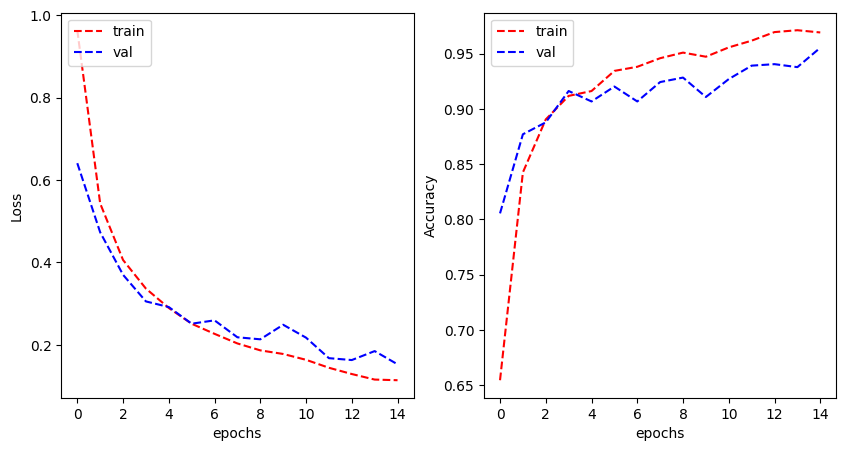

In [21]:
plot_learning_curve(history_shape_ann.history['loss'], history_shape_ann.history['val_loss'], 
                    history_shape_ann.history['categorical_accuracy'], history_shape_ann.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [22]:
# Assuming 'validation_generator_shape' is your data generator for validation data
# Make sure to reset the generator before making predictions

validation_generator_shape.reset()
validation_shape_predictions = model_sign_shape_ann.predict(validation_generator_shape)
validation_shape_predicted_classes = np.argmax(validation_shape_predictions, axis=1)

# Retrieve the true labels
validation_shape_true_classes = validation_generator_shape.classes

print(classification_report(validation_shape_true_classes, validation_shape_predicted_classes, target_names=validation_generator_shape.class_indices.keys()))
#print(accuracy_score(test_true_classes, test_predicted_classes))

24/24 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

     diamond       0.93      0.95      0.94        55
         hex       1.00      0.78      0.88         9
       round       0.96      0.97      0.96       345
      square       0.98      0.90      0.94       133
    triangle       0.94      0.98      0.96       198

    accuracy                           0.96       740
   macro avg       0.96      0.92      0.94       740
weighted avg       0.96      0.96      0.96       740



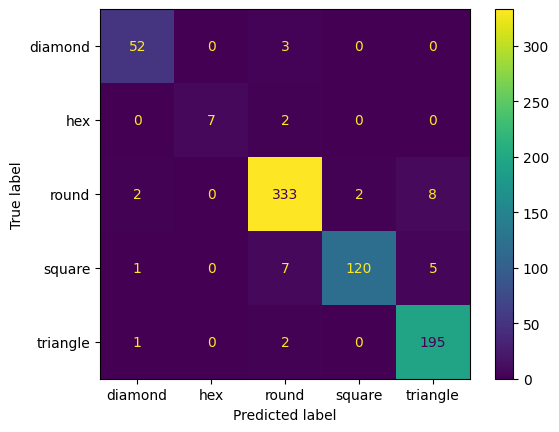

In [23]:
shape_ann_cm = ConfusionMatrixDisplay.from_predictions(
    validation_shape_true_classes, validation_shape_predicted_classes,
    display_labels=validation_generator_shape.class_indices.keys())

Found 740 validated image filenames belonging to 5 classes.


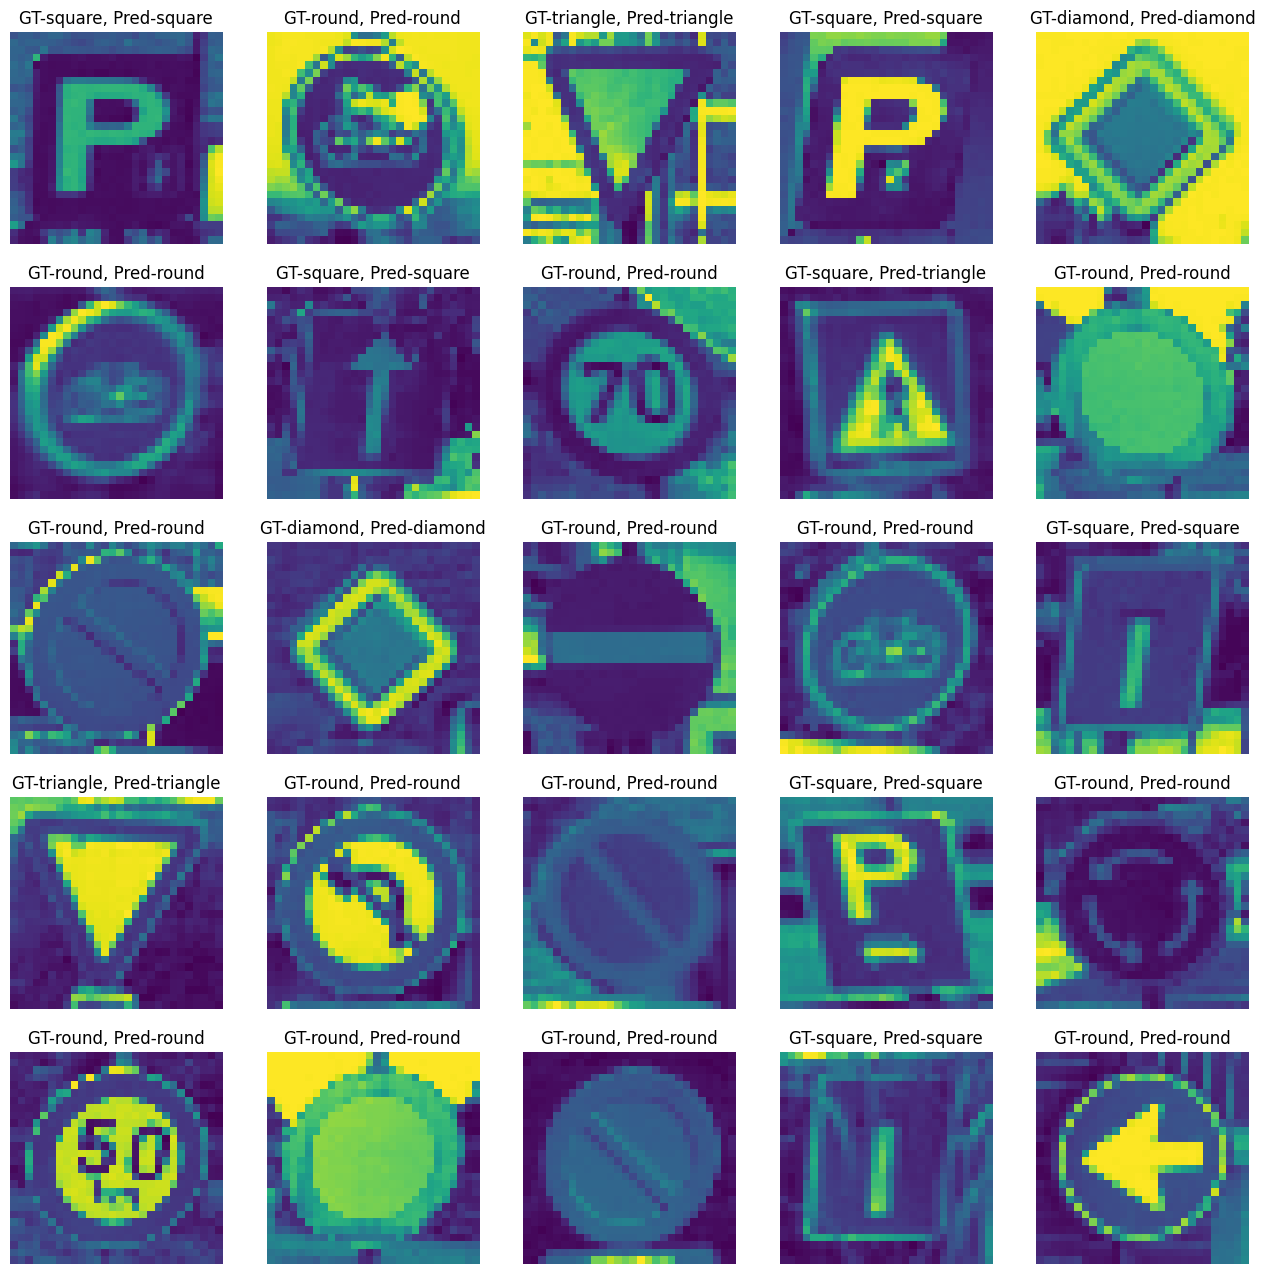

In [24]:
# randomly pick images and show prediction
show_image_prediction(model_sign_shape_ann, "sign_shape", validation_generator_shape.class_indices, val_data)

#### ANN for TYPE Shape

In [25]:
INPUT_DIM = (28,28,1)
HIDDEN_LAYER_DIM = 256
TYPE_OUTPUT_CLASSES = 16
model_sign_type_ann = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(TYPE_OUTPUT_CLASSES)
])
model_sign_type_ann.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'])

model_sign_type_ann.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dense_3 (Dense)             (None, 16)                4112      
                                                                 
Total params: 205072 (801.06 KB)
Trainable params: 205072 (801.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# Setup the ImageDataGenerators
train_datagen_type = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen_type = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

# Create generators that will read images from the dataframe and process them
train_generator_type = train_datagen_type.flow_from_dataframe(
    dataframe=train_data,
    directory='./',
    x_col="filepath",
    y_col="sign_type",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    seed=42)

validation_generator_type = val_datagen_type.flow_from_dataframe(
    dataframe=val_data,
    directory='./',
    x_col="filepath",
    y_col="sign_type",
    target_size=(28, 28),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    seed=42)

# test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
# 
# test_generator_shape = test_datagen.flow_from_dataframe(
#     dataframe=test_data,
#     directory='./',
#     x_col="filepath",
#     y_col="sign_shape_num",
#     target_size=(28, 28),
#     batch_size=1,
#     class_mode='categorical',
#     color_mode='grayscale',
#     shuffle = False,
#     seed=42)

Found 2959 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [27]:
# Check what the generator yields
x_batch, y_batch = next(train_generator_type)
print(x_batch.shape, y_batch.shape)  # This should output something like (32, 28, 28, 1) for x_batch and (32, num_classes) for y_batch
train_generator_type.reset()

(32, 28, 28, 1) (32, 16)


In [28]:
history_type_ann = model_sign_type_ann.fit(train_generator_type, validation_data = validation_generator_type, epochs=15, verbose=1)

Epoch 1/15
93/93 [==============================] - 1s 4ms/step - loss: 1.8527 - categorical_accuracy: 0.5052 - val_loss: 1.3031 - val_categorical_accuracy: 0.6635
Epoch 2/15
93/93 [==============================] - 0s 4ms/step - loss: 1.0450 - categorical_accuracy: 0.7577 - val_loss: 0.8520 - val_categorical_accuracy: 0.8000
Epoch 3/15
93/93 [==============================] - 0s 4ms/step - loss: 0.7312 - categorical_accuracy: 0.8466 - val_loss: 0.6505 - val_categorical_accuracy: 0.8446
Epoch 4/15
93/93 [==============================] - 0s 4ms/step - loss: 0.5691 - categorical_accuracy: 0.8821 - val_loss: 0.5349 - val_categorical_accuracy: 0.8716
Epoch 5/15
93/93 [==============================] - 0s 4ms/step - loss: 0.4777 - categorical_accuracy: 0.9030 - val_loss: 0.4670 - val_categorical_accuracy: 0.8865
Epoch 6/15
93/93 [==============================] - 0s 4ms/step - loss: 0.4122 - categorical_accuracy: 0.9111 - val_loss: 0.3831 - val_categorical_accuracy: 0.9176
Epoch 7/15
93/93

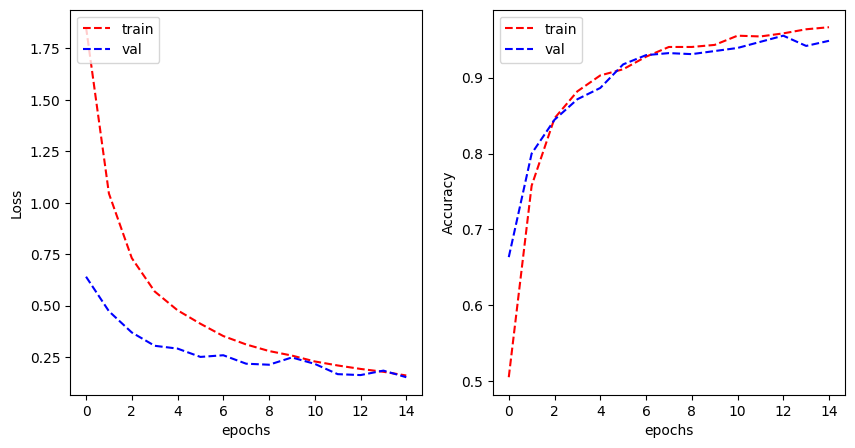

In [29]:
plot_learning_curve(history_type_ann.history['loss'], history_shape_ann.history['val_loss'],
                    history_type_ann.history['categorical_accuracy'], history_type_ann.history['val_categorical_accuracy'],
                    metric_name='Accuracy')

In [30]:
# Assuming 'validation_generator_shape' is your data generator for validation data
# Make sure to reset the generator before making predictions

validation_generator_type.reset()
validation_type_predictions = model_sign_type_ann.predict(validation_generator_type)
validation_type_predicted_classes = np.argmax(validation_type_predictions, axis=1)

# Retrieve the true labels
validation_type_true_classes = validation_generator_type.classes

print(classification_report(validation_type_true_classes, validation_type_predicted_classes, target_names=validation_generator_type.class_indices.keys()))
#print(accuracy_score(validation_type_true_classes, validation_type_predicted_classes))

24/24 [==============================] - 0s 3ms/step
                  precision    recall  f1-score   support

         bicycle       0.98      0.91      0.94        55
        continue       1.00      0.98      0.99        47
        crossing       0.89      1.00      0.94        17
         giveway       1.00      0.96      0.98        54
         laneend       1.00      0.80      0.89        25
  limitedtraffic       0.91      0.84      0.87        25
         noentry       0.92      0.98      0.95        60
       noparking       0.76      0.96      0.85        55
         parking       0.98      1.00      0.99        44
      rightofway       0.98      0.91      0.94        55
      roundabout       1.00      0.94      0.97        17
           speed       0.98      0.91      0.95        68
            stop       1.00      1.00      1.00         9
trafficdirective       0.86      1.00      0.92        43
 traveldirection       1.00      0.86      0.93        22
         warning  

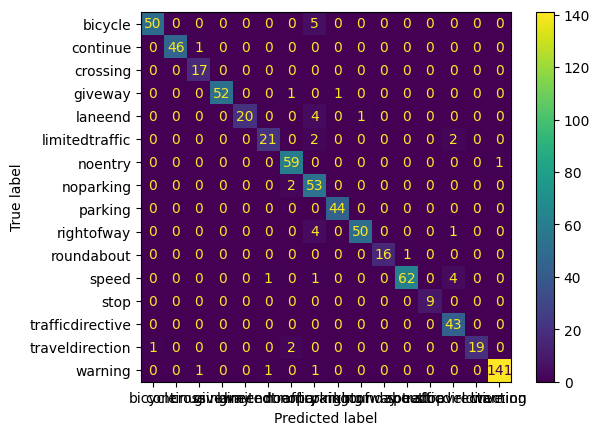

In [31]:
type_ann_cm = ConfusionMatrixDisplay.from_predictions(
    validation_type_true_classes, validation_type_predicted_classes,
    display_labels=validation_generator_type.class_indices.keys())

Found 740 validated image filenames belonging to 16 classes.


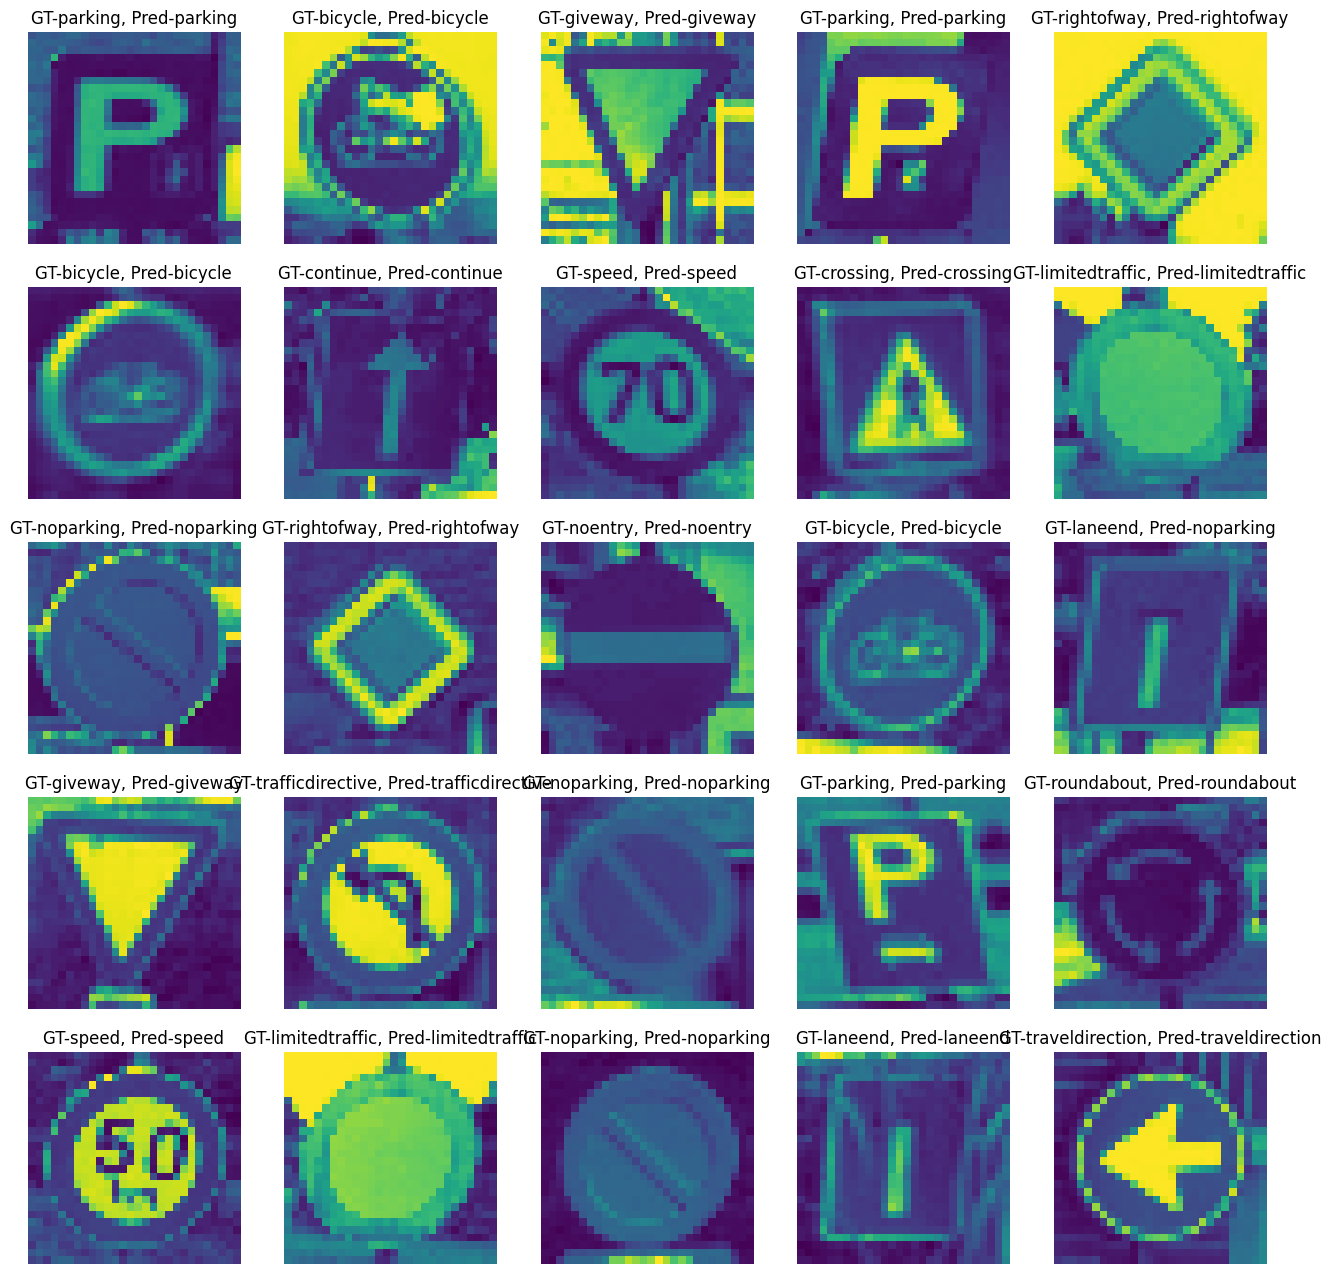

In [32]:
# randomly pick images and show prediction
show_image_prediction(model_sign_type_ann, "sign_type", validation_generator_type.class_indices, val_data)